# Loading Data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from itertools import product
%matplotlib inline

In [2]:
DATA_FOLDER = 'competitive-data-science-final-project/'

sales = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
submit = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv.gz'))

In [3]:
print(sales.shape)
print(items.shape)
print(item_categories.shape)
print(shops.shape)
print(test.shape)
print(submit.shape)

(2935849, 6)
(22170, 3)
(84, 2)
(60, 2)
(214200, 3)
(214200, 2)


# EDA

In [4]:
sales_tmp = sales.copy()
sales_tmp['day'] = sales_tmp['date'].map(lambda x: x.split('.')[0]).astype('int')
sales_tmp['month'] = sales_tmp['date'].map(lambda x: x.split('.')[1]).astype('int')
sales_tmp['year'] = sales_tmp['date'].map(lambda x: x.split('.')[2]).astype('int')
sales_tmp['item_amount'] = sales_tmp['item_price'] * sales_tmp['item_cnt_day']

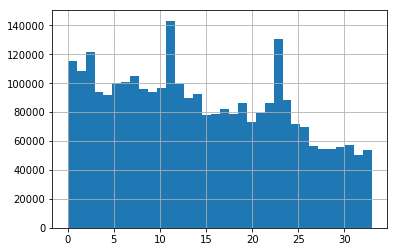

In [5]:
sales_tmp['date_block_num'].hist(bins=34)

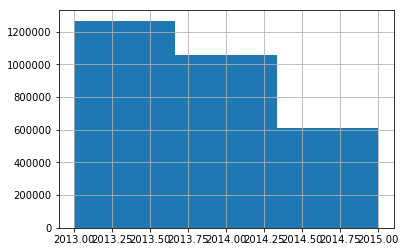

In [6]:
sales_tmp['year'].hist(bins=3)

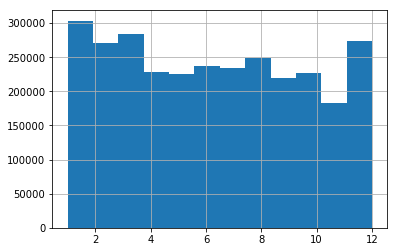

In [7]:
sales_tmp['month'].hist(bins=12)

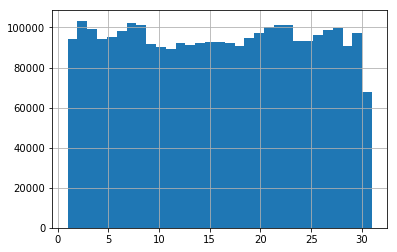

In [8]:
sales_tmp['day'].hist(bins=31)

In [9]:
sales_tmp_items = pd.merge(sales_tmp, items, on='item_id')

    day  item_cnt_day
0     1      114560.0
1     2      127587.0
2     3      123944.0
3     4      119028.0
4     5      121332.0
5     6      121241.0
6     7      124773.0
7     8      120934.0
8     9      111262.0
9    10      107277.0
10   11      106910.0
11   12      111021.0
12   13      112092.0
13   14      118212.0
14   15      116134.0
15   16      111202.0
16   17      115225.0
17   18      113608.0
18   19      123257.0
19   20      120719.0
20   21      125358.0
21   22      126714.0
22   23      124726.0
23   24      112871.0
24   25      115450.0
25   26      118728.0
26   27      126086.0
27   28      126825.0
28   29      120842.0
29   30      126466.0
30   31       83822.0


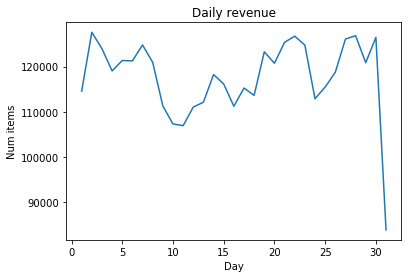

In [10]:
ret = sales_tmp_items.groupby(['day'],as_index=False).agg({"item_cnt_day": pd.Series.sum})
print(ret)
plt.plot(ret['day'].astype(int), ret['item_cnt_day'].astype(int))
plt.ylabel('Num items')
plt.xlabel('Day')
plt.title("Daily revenue")
plt.show()

   year  item_cnt_day
0  2013     1562733.0
1  2014     1320889.0
2  2015      764584.0


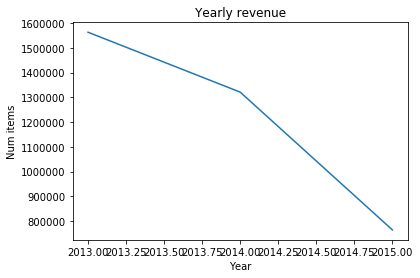

In [11]:
ret = sales_tmp_items.groupby(['year'],as_index=False).agg({"item_cnt_day": pd.Series.sum})
print(ret)
plt.plot(ret['year'].astype(int), ret['item_cnt_day'].astype(int))
plt.ylabel('Num items')
plt.xlabel('Year')
plt.title("Yearly revenue")
plt.show()

    month  item_cnt_day
0       1      359349.0
1       2      321975.0
2       3      344453.0
3       4      281573.0
4       5      277055.0
5       6      286924.0
6       7      271433.0
7       8      294091.0
8       9      305383.0
9      10      306019.0
10     11      247854.0
11     12      352097.0


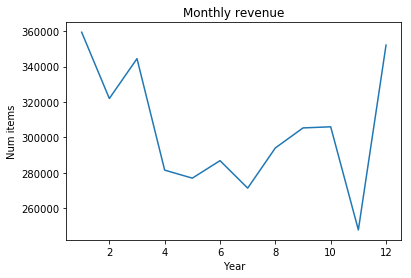

In [12]:
ret = sales_tmp_items.groupby(['month'],as_index=False).agg({"item_cnt_day": pd.Series.sum})
print(ret)
plt.plot(ret['month'].astype(int), ret['item_cnt_day'].astype(int))
plt.ylabel('Num items')
plt.xlabel('Year')
plt.title("Monthly revenue")
plt.show()

    date_block_num  item_cnt_day
0                0      131479.0
1                1      128090.0
2                2      147142.0
3                3      107190.0
4                4      106970.0
5                5      125381.0
6                6      116966.0
7                7      125291.0
8                8      133332.0
9                9      127541.0
10              10      130009.0
11              11      183342.0
12              12      116899.0
13              13      109687.0
14              14      115297.0
15              15       96556.0
16              16       97790.0
17              17       97429.0
18              18       91280.0
19              19      102721.0
20              20       99208.0
21              21      107422.0
22              22      117845.0
23              23      168755.0
24              24      110971.0
25              25       84198.0
26              26       82014.0
27              27       77827.0
28              28       72295.0
29        

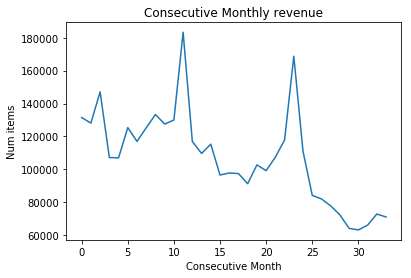

In [13]:
ret = sales_tmp_items.groupby(['date_block_num'],as_index=False).agg({"item_cnt_day": pd.Series.sum})
print(ret)
plt.plot(ret['date_block_num'].astype(int), ret['item_cnt_day'].astype(int))
plt.ylabel('Num items')
plt.xlabel('Consecutive Month')
plt.title("Consecutive Monthly revenue")
plt.show()

# Features Extraction

In [14]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
    
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'},'item_price': {'item_price':np.mean}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

all_data = pd.merge(all_data,items,on=['item_id'],how='left')
all_data.drop('item_name', axis=1, inplace=True)

all_data['item_amount'] = all_data['item_price'] * all_data['target']

print(all_data.shape)
all_data.head()

C:\Users\fqelv\Anaconda3\envs\py35\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


(10913850, 7)


,shop_id,item_id,date_block_num,item_price,target,item_category_id,item_amount
0,0,19,0,0.0,0.0,40,0.0
1,0,27,0,0.0,0.0,19,0.0
2,0,28,0,0.0,0.0,30,0.0
3,0,29,0,0.0,0.0,23,0.0
4,0,32,0,221.0,6.0,40,1326.0


In [15]:
train1 = all_data.copy()

In [16]:
for type_id in ['item_id','shop_id','item_category_id']:
    for column_id,aggregator,aggtype in [('item_price',np.mean,'avg'),('target',np.sum,'sum'),('target',np.mean,'avg'),('item_amount',np.sum,'sum')]:

        mean_df = train1.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']

        train1 = pd.merge(train1,mean_df,on=['date_block_num',type_id],how='left')

''' These Features are created by myself but alwasy give a score around 0.96. For xgb4 and xgb5
globalmean = all_data.target.mean()

#date_block_num + item_id + mean
train1['date_block_num_item_id_mean_target'] = np.nan
cumsum = train1.groupby(['date_block_num','item_id'])['target'].cumsum() - train1['target']
cumcnt = train1.groupby(['date_block_num','item_id'])['target'].cumcount()
train1['date_block_num_item_id_mean_target'] = cumsum/cumcnt
train1['date_block_num_item_id_mean_target'].fillna(globalmean, inplace=True)
encoded_feature = train1['date_block_num_item_id_mean_target'].values
corr = np.corrcoef(train1['target'].values, encoded_feature)[0][1]
print(corr)

#date_block_num + item_id + sum
temp_df = train1.groupby(['item_id','date_block_num']).agg(np.sum).reset_index()[['target','item_id','date_block_num']]
temp_df.columns = ['date_block_num_item_id_sum_target', 'item_id','date_block_num']
train1 = pd.merge(train1,temp_df,on=['date_block_num', 'item_id'],how='left')
train1['date_block_num_item_id_sum_target'].fillna(0, inplace=True)
encoded_feature = train1['date_block_num_item_id_sum_target'].values
corr = np.corrcoef(train1['target'].values, encoded_feature)[0][1]
print(corr)


#date_block_num + item_category_id + mean
train1['date_block_num_item_category_id_mean_target'] = np.nan
cumsum = train1.groupby(['date_block_num','item_category_id'])['target'].cumsum() - train1['target']
cumcnt = train1.groupby(['date_block_num','item_category_id'])['target'].cumcount()
train1['date_block_num_item_category_id_mean_target'] = cumsum/cumcnt
train1['date_block_num_item_category_id_mean_target'].fillna(globalmean, inplace=True)
encoded_feature = train1['date_block_num_item_category_id_mean_target'].values
corr = np.corrcoef(train1['target'].values, encoded_feature)[0][1]
print(corr)


#date_block_num + item_category_id + sum
temp_df = train1.groupby(['shop_id','date_block_num']).agg(np.sum).reset_index()[['target','shop_id','date_block_num']]
temp_df.columns = ['date_block_num_shop_id_sum_target', 'shop_id','date_block_num']
train1 = pd.merge(train1,temp_df,on=['date_block_num', 'shop_id'],how='left')
train1['date_block_num_shop_id_sum_target'].fillna(0, inplace=True)
encoded_feature = train1['date_block_num_shop_id_sum_target'].values
corr = np.corrcoef(train1['target'].values, encoded_feature)[0][1]
print(corr)


#date_block_num + shop_id + item_id + mean
train1['date_block_num_shop_id_mean_target'] = np.nan
cumsum = train1.groupby(['date_block_num','shop_id'])['target'].cumsum() - train1['target']
cumcnt = train1.groupby(['date_block_num','shop_id'])['target'].cumcount()
train1['date_block_num_shop_id_mean_target'] = cumsum/cumcnt
train1['date_block_num_shop_id_mean_target'].fillna(globalmean, inplace=True)
encoded_feature = train1['date_block_num_shop_id_mean_target'].values
corr = np.corrcoef(train1['target'].values, encoded_feature)[0][1]
print(corr)


#date_block_num + shop_id + item_id + sum
temp_df = train1.groupby(['item_id','shop_id','date_block_num']).agg(np.sum).reset_index()[['target','item_id','shop_id','date_block_num']]
temp_df.columns = ['date_block_num_shop_id_item_id_sum_target', 'item_id','shop_id','date_block_num']
train1 = pd.merge(train1,temp_df,on=['date_block_num', 'shop_id','item_id'],how='left')
train1['date_block_num_shop_id_item_id_sum_target'].fillna(0, inplace=True)
encoded_feature = train1['date_block_num_shop_id_item_id_sum_target'].values
corr = np.corrcoef(train1['target'].values, encoded_feature)[0][1]
print(corr)


#date_block_num + shop_id + item_category_id + mean
train1['date_block_num_shop_id_item_category_id_mean_target'] = np.nan
cumsum = train1.groupby(['date_block_num','shop_id','item_category_id'])['target'].cumsum() - train1['target']
cumcnt = train1.groupby(['date_block_num','shop_id','item_category_id'])['target'].cumcount()
train1['date_block_num_shop_id_item_category_id_mean_target'] = cumsum/cumcnt
train1['date_block_num_shop_id_item_category_id_mean_target'].fillna(globalmean, inplace=True)
encoded_feature = train1['date_block_num_shop_id_item_category_id_mean_target'].values
corr = np.corrcoef(train1['target'].values, encoded_feature)[0][1]
print(corr)


#date_block_num + shop_id + item_category_id + sum
temp_df = train1.groupby(['item_category_id','shop_id','date_block_num']).agg(np.sum).reset_index()[['target','item_category_id','shop_id','date_block_num']]
temp_df.columns = ['date_block_num_shop_id_item_category_id_sum_target', 'item_category_id','shop_id','date_block_num']
train1 = pd.merge(train1,temp_df,on=['date_block_num', 'shop_id', 'item_category_id'],how='left')
train1['date_block_num_shop_id_item_category_id_sum_target'].fillna(0, inplace=True)
encoded_feature = train1['date_block_num_shop_id_item_category_id_sum_target'].values
corr = np.corrcoef(train1['target'].values, encoded_feature)[0][1]
print(corr)
'''

" These Features are created by myself but alwasy give a score around 0.96. For xgb4 and xgb5\nglobalmean = all_data.target.mean()\n\n#date_block_num + item_id + mean\ntrain1['date_block_num_item_id_mean_target'] = np.nan\ncumsum = train1.groupby(['date_block_num','item_id'])['target'].cumsum() - train1['target']\ncumcnt = train1.groupby(['date_block_num','item_id'])['target'].cumcount()\ntrain1['date_block_num_item_id_mean_target'] = cumsum/cumcnt\ntrain1['date_block_num_item_id_mean_target'].fillna(globalmean, inplace=True)\nencoded_feature = train1['date_block_num_item_id_mean_target'].values\ncorr = np.corrcoef(train1['target'].values, encoded_feature)[0][1]\nprint(corr)\n\n#date_block_num + item_id + sum\ntemp_df = train1.groupby(['item_id','date_block_num']).agg(np.sum).reset_index()[['target','item_id','date_block_num']]\ntemp_df.columns = ['date_block_num_item_id_sum_target', 'item_id','date_block_num']\ntrain1 = pd.merge(train1,temp_df,on=['date_block_num', 'item_id'],how='lef

In [17]:
test1 = test.copy()

test1['date_block_num'] = 34
test1 = test1.merge(items, how='left', on='item_id')
test1.drop('item_name', axis=1, inplace=True)

In [18]:
train1

,shop_id,item_id,date_block_num,item_price,target,item_category_id,item_amount,item_id_avg_item_price,item_id_sum_target,item_id_avg_target,item_id_sum_item_amount,shop_id_avg_item_price,shop_id_sum_target,shop_id_avg_target,shop_id_sum_item_amount,item_category_id_avg_item_price,item_category_id_sum_target,item_category_id_avg_target,item_category_id_sum_item_amount
0,0,19,0,0.0,0.0,40,0.0,0.622222,1.0,0.022222,28.000000,129.906273,5578.0,0.687369,2.966061e+06,35.657887,33489.0,0.310860,8.667498e+06
1,0,27,0,0.0,0.0,19,0.0,361.666667,7.0,0.155556,16275.000000,129.906273,5578.0,0.687369,2.966061e+06,471.525427,8983.0,0.849456,1.410452e+07
2,0,28,0,0.0,0.0,30,0.0,61.000000,8.0,0.177778,4392.000000,129.906273,5578.0,0.687369,2.966061e+06,127.125779,22216.0,1.189612,1.002290e+07
3,0,29,0,0.0,0.0,23,0.0,208.600000,4.0,0.088889,9387.000000,129.906273,5578.0,0.687369,2.966061e+06,465.084617,4150.0,0.548942,7.663657e+06
4,0,32,0,221.0,6.0,40,1326.0,275.479240,299.0,6.644444,101512.085240,129.906273,5578.0,0.687369,2.966061e+06,35.657887,33489.0,0.310860,8.667498e+06
5,0,33,0,347.0,3.0,37,1041.0,325.911111,61.0,1.355556,29831.000000,129.906273,5578.0,0.687369,2.966061e+06,63.014719,6094.0,0.199738,2.843926e+06
6,0,34,0,0.0,0.0,40,0.0,24.866667,9.0,0.200000,1268.000000,129.906273,5578.0,0.687369,2.966061e+06,35.657887,33489.0,0.310860,8.667498e+06
7,0,35,0,247.0,1.0,40,247.0,206.044444,78.0,1.733333,30210.000000,129.906273,5578.0,0.687369,2.966061e+06,35.657887,33489.0,0.310860,8.667498e+06
8,0,40,0,0.0,0.0,57,0.0,19.488889,4.0,0.088889,877.000000,129.906273,5578.0,0.687369,2.966061e+06,28.006554,1539.0,0.130534,4.272049e+05
9,0,41,0,0.0,0.0,57,0.0,36.088889,9.0,0.200000,2003.000000,129.906273,5578.0,0.687369,2.966061e+06,28.006554,1539.0,0.130534,4.272049e+05


In [19]:
train1 = pd.concat([train1,test1], axis=0, ignore_index=True)

lag_variables  = ['item_id_avg_item_price',
'item_id_sum_target',
'item_id_avg_target',
'item_id_sum_item_amount',
'shop_id_avg_item_price',
'shop_id_sum_target',
'shop_id_avg_target',
'shop_id_sum_item_amount',
'item_category_id_avg_item_price',
'item_category_id_sum_target',
'item_category_id_avg_target',
'item_category_id_sum_item_amount',
'target']

lags = [1 ,2 ,3, 12]
for lag in lags:
    train1_tmp = train1.copy()
    train1_tmp.date_block_num+=lag
    train1_tmp = train1_tmp[['date_block_num','shop_id','item_id']+lag_variables]
    train1_tmp.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'-lag-'+str(lag) for lag_feat in lag_variables]
    train1 = train1.merge(train1_tmp,on=['date_block_num','shop_id','item_id'] ,how='left')

''' For xgb4 and xgb5
lag_variables1  = ['date_block_num_item_id_mean_target',
'date_block_num_item_category_id_mean_target',
'date_block_num_shop_id_mean_target',
'date_block_num_shop_id_item_category_id_mean_target']

lag_variables2  = ['date_block_num_item_id_sum_target',
'date_block_num_shop_id_sum_target',
'date_block_num_shop_id_item_id_sum_target',
'date_block_num_shop_id_item_category_id_sum_target']


#Limited by computation resource
lags = [1,2,3,6,12]
#lags = [1, 2, 3, 4, 5, 6, 9, 12]

for lag in lags:
    train1_tmp = train1.copy()
    train1_tmp.date_block_num += lag
    train1_tmp = train1_tmp[['date_block_num','shop_id','item_id']+lag_variables1]
    train1_tmp.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'-lag-'+str(lag) for lag_feat in lag_variables1]
    train1 = train1.merge(train1_tmp,on=['date_block_num','shop_id','item_id'] ,how='left')
    for lag_feat in lag_variables1:
        train1[lag_feat+'-lag-'+str(lag)].fillna(0, inplace=True)
    
for lag in lags:
    train1_tmp = train1.copy()
    train1_tmp.date_block_num += lag
    train1_tmp = train1_tmp[['date_block_num','shop_id','item_id']+lag_variables2]
    train1_tmp.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'-lag-'+str(lag) for lag_feat in lag_variables2]
    train1 = train1.merge(train1_tmp,on=['date_block_num','shop_id','item_id'] ,how='left')
    for lag_feat in lag_variables2:
        train1[lag_feat+'-lag-'+str(lag)].fillna(0, inplace=True)
'''

" For xgb4 and xgb5\nlag_variables1  = ['date_block_num_item_id_mean_target',\n'date_block_num_item_category_id_mean_target',\n'date_block_num_shop_id_mean_target',\n'date_block_num_shop_id_item_category_id_mean_target']\n\nlag_variables2  = ['date_block_num_item_id_sum_target',\n'date_block_num_shop_id_sum_target',\n'date_block_num_shop_id_item_id_sum_target',\n'date_block_num_shop_id_item_category_id_sum_target']\n\n\n#Limited by computation resource\nlags = [1,2,3,6,12]\n#lags = [1, 2, 3, 4, 5, 6, 9, 12]\n\nfor lag in lags:\n    train1_tmp = train1.copy()\n    train1_tmp.date_block_num += lag\n    train1_tmp = train1_tmp[['date_block_num','shop_id','item_id']+lag_variables1]\n    train1_tmp.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'-lag-'+str(lag) for lag_feat in lag_variables1]\n    train1 = train1.merge(train1_tmp,on=['date_block_num','shop_id','item_id'] ,how='left')\n    for lag_feat in lag_variables1:\n        train1[lag_feat+'-lag-'+str(lag)].fillna(0, inpla

In [20]:
#train1 = train1[train1['date_block_num']>12]
#cols_to_drop = lag_variables1[:] + lag_variables2[:]
cols_to_drop = ['item_id_avg_item_price',
'item_id_sum_target',
'item_id_avg_target',
'item_id_sum_item_amount',
'shop_id_avg_item_price',
'shop_id_sum_target',
'shop_id_avg_target',
'shop_id_sum_item_amount',
'item_category_id_avg_item_price',
'item_category_id_sum_target',
'item_category_id_avg_target',
'item_category_id_sum_item_amount']
train1 = train1.drop(cols_to_drop, axis=1)

In [21]:
train1 = train1.reset_index().drop(['index'], axis=1)

# KNN Features
## But it turns out not much helpful to the final score

In [22]:
import sklearn

for p in [sklearn]:
    print (p.__name__, p.__version__)

sklearn 0.18.1


In [24]:
KNNCols = [lag_feat+'-lag-'+str(lag) for lag in lags for lag_feat in lag_variables]# + [lag_feat+'-lag-'+str(lag) for lag in lags for lag_feat in lag_variables2]
print(len(KNNCols))

52


In [25]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import NearestNeighbors
from multiprocessing import Pool

import numpy as np
import pickle

class NearestNeighborsFeats(BaseEstimator, ClassifierMixin):
    '''
        This class should implement KNN features extraction 
    '''
    def __init__(self, n_jobs, k_list, metric, n_classes=None, n_neighbors=None, eps=1e-6):
        self.n_jobs = n_jobs
        self.k_list = k_list
        self.metric = metric
        
        if n_neighbors is None:
            self.n_neighbors = max(k_list) 
        else:
            self.n_neighbors = n_neighbors
            
        self.eps = eps        
        self.n_classes_ = n_classes
    
    def fit(self, X, y):
        '''
            Set's up the train set and self.NN object
        '''
        
        '''
        # Create a NearestNeighbors (NN) object. We will use it in `predict` function 
        self.NN = NearestNeighbors(n_neighbors=max(self.k_list), 
                                      metric=self.metric, 
                                      n_jobs=1, 
                                      algorithm='brute' if self.metric=='cosine' else 'auto')
        self.NN.fit(X)
        
        pickle.dump(self.NN, open('KNN_model.sav', 'wb'))
        '''
        self.NN = pickle.load(open("KNN_model.sav", "rb"))
        # Store labels 
        self.y_train = y
        
        self.X_train = X
        
        # Save how many classes we have
        self.n_classes = np.unique(y).shape[0] if self.n_classes_ is None else self.n_classes_
        
        
    def predict(self, X):       
        '''
            Produces KNN features for every object of a dataset X
        '''
        if self.n_jobs == 1:
            test_feats = []
            for i in range(X.shape[0]):
                test_feats.append(self.get_features_for_one(X[i:i+1]))
                if i % 1000 == 0:
                    print(str(i) + '/'+str(X.shape[0]))
                    
                if (i+1) % 500000 == 0 or i+1 == X.shape[0]:
                    # Dump the features to disk
                    np.save('knn_feats_%s_test.npy' % str(i) , np.vstack(test_feats))
                    test_feats = []
        else:
            '''
                 *Make it parallel*
                     Number of threads should be controlled by `self.n_jobs`  
                     
                     
                     You can use whatever you want to do it
                     For Python 3 the simplest option would be to use 
                     `multiprocessing.Pool` (but don't use `multiprocessing.dummy.Pool` here)
                     You may try use `joblib` but you will most likely encounter an error, 
                     that you will need to google up (and eventually it will work slowly)
                     
                     For Python 2 I also suggest using `multiprocessing.Pool` 
                     You will need to use a hint from this blog 
                     http://qingkaikong.blogspot.ru/2016/12/python-parallel-method-in-class.html
                     I could not get `joblib` working at all for this code 
                     (but in general `joblib` is very convenient)
                     
            '''
            
            # YOUR CODE GOES HERE
            # test_feats =  # YOUR CODE GOES HERE
            test_feats =[]
            
            pool = Pool(processes = self.n_jobs) 
            test_feats = [pool.apply_async(self.get_features_for_one, (X[i:i+1],)) for i in range(X.shape[0])]          
            test_feats = [res.get() for res in test_feats]
            pool.close()
            pool.join()
            # YOUR CODE GOES HERE
            
            #assert False, 'You need to implement it for n_jobs > 1'
            
        #return np.vstack(test_feats)
        
        
    def get_features_for_one(self, x):
        '''
            Computes KNN features for a single object `x`
        '''

        NN_output = self.NN.kneighbors(x)
        
        # Vector of size `n_neighbors`
        # Stores indices of the neighbors
        neighs = NN_output[1][0]
        
        # Vector of size `n_neighbors`
        # Stores distances to corresponding neighbors
        neighs_dist = NN_output[0][0] 

        # Vector of size `n_neighbors`
        # Stores labels of corresponding neighbors
        neighs_y = self.y_train[neighs] 
        
        neighs_X = self.X_train.iloc[neighs]
        
        ## ========================================== ##
        ##              YOUR CODE BELOW
        ## ========================================== ##
        
        # We will accumulate the computed features here
        # Eventually it will be a list of lists or np.arrays
        # and we will use np.hstack to concatenate those
        return_list = [] 
        
        ''' 
            1. Fraction of objects of every class.
               It is basically a KNNСlassifiers predictions.

               Take a look at `np.bincount` function, it can be very helpful
               Note that the values should sum up to one
        '''
        feats = []
        for k in self.k_list:
            #for col in KNNCols:
            feat = neighs_X[:k][KNNCols].sum(axis=0) / k
            feats.append(feat.tolist())
        
        #return_list += [feats]
        return_list += feats
                
        #print(return_list)
        '''
            5. 
               5.1 Distance to Kth neighbor
                   Think of this as of quantiles of a distribution
               5.2 Distance to Kth neighbor normalized by 
                   distance to the first neighbor
               
               feat_51, feat_52 are answers to 5.1. and 5.2.
               should be scalars
               
               Do not forget to add self.eps to denominator.
        '''
        for k in self.k_list:
            # YOUR CODE GOES HERE
            feat_51 = neighs_dist[k-1]
            feat_52 = neighs_dist[k-1] / (self.eps + neighs_dist[0])
            # YOUR CODE GOES HERE
            
            return_list += [[feat_51, feat_52]]
        
        #print(return_list)
        
        # merge
        knn_feats = np.hstack(return_list)
        #print(len(knn_feats))
        #print(knn_feats)
        
        return knn_feats

In [15]:
# a list of K in KNN, starts with one 
k_list = [15]
for metric in ['minkowski']:#, 'cosine']:
    
    # Create instance of our KNN feature extractor
    NNF = NearestNeighborsFeats(n_jobs=1, k_list=k_list, metric=metric)
    
    # Fit on train set
    NNF.fit(train1[cols], train1['target'])
    print('NNF Fit Complete!')

    # Get features for test
    #test_knn_feats = 
    NNF.predict(train1[cols])
    
    # Dump the features to disk
    #np.save('data/knn_feats_%s_test.npy' % metric , test_knn_feats)

NNF Fit Complete!
0/6291948
1000/6291948
2000/6291948
3000/6291948
4000/6291948
5000/6291948
6000/6291948
7000/6291948
8000/6291948
9000/6291948
10000/6291948
11000/6291948
12000/6291948
13000/6291948
14000/6291948
15000/6291948
16000/6291948
17000/6291948
18000/6291948
19000/6291948
20000/6291948
21000/6291948
22000/6291948
23000/6291948
24000/6291948
25000/6291948
26000/6291948
27000/6291948
28000/6291948
29000/6291948
30000/6291948
31000/6291948
32000/6291948
33000/6291948
34000/6291948
35000/6291948
36000/6291948
37000/6291948
38000/6291948
39000/6291948
40000/6291948
41000/6291948
42000/6291948
43000/6291948
44000/6291948
45000/6291948
46000/6291948
47000/6291948
48000/6291948
49000/6291948
50000/6291948
51000/6291948
52000/6291948
53000/6291948
54000/6291948
55000/6291948
56000/6291948
57000/6291948
58000/6291948
59000/6291948
60000/6291948
61000/6291948
62000/6291948
63000/6291948
64000/6291948
65000/6291948
66000/6291948
67000/6291948
68000/6291948
69000/6291948
70000/6291948
7

553000/6291948
554000/6291948
555000/6291948
556000/6291948
557000/6291948
558000/6291948
559000/6291948
560000/6291948
561000/6291948
562000/6291948
563000/6291948
564000/6291948
565000/6291948
566000/6291948
567000/6291948
568000/6291948
569000/6291948
570000/6291948
571000/6291948
572000/6291948
573000/6291948
574000/6291948
575000/6291948
576000/6291948
577000/6291948
578000/6291948
579000/6291948
580000/6291948
581000/6291948
582000/6291948
583000/6291948
584000/6291948
585000/6291948
586000/6291948
587000/6291948
588000/6291948
589000/6291948
590000/6291948
591000/6291948
592000/6291948
593000/6291948
594000/6291948
595000/6291948
596000/6291948
597000/6291948
598000/6291948
599000/6291948
600000/6291948
601000/6291948
602000/6291948
603000/6291948
604000/6291948
605000/6291948
606000/6291948
607000/6291948
608000/6291948
609000/6291948
610000/6291948
611000/6291948
612000/6291948
613000/6291948
614000/6291948
615000/6291948
616000/6291948
617000/6291948
618000/6291948
619000/629

1093000/6291948
1094000/6291948
1095000/6291948
1096000/6291948
1097000/6291948
1098000/6291948
1099000/6291948
1100000/6291948
1101000/6291948
1102000/6291948
1103000/6291948
1104000/6291948
1105000/6291948
1106000/6291948
1107000/6291948
1108000/6291948
1109000/6291948
1110000/6291948
1111000/6291948
1112000/6291948
1113000/6291948
1114000/6291948
1115000/6291948
1116000/6291948
1117000/6291948
1118000/6291948
1119000/6291948
1120000/6291948
1121000/6291948
1122000/6291948
1123000/6291948
1124000/6291948
1125000/6291948
1126000/6291948
1127000/6291948
1128000/6291948
1129000/6291948
1130000/6291948
1131000/6291948
1132000/6291948
1133000/6291948
1134000/6291948
1135000/6291948
1136000/6291948
1137000/6291948
1138000/6291948
1139000/6291948
1140000/6291948
1141000/6291948
1142000/6291948
1143000/6291948
1144000/6291948
1145000/6291948
1146000/6291948
1147000/6291948
1148000/6291948
1149000/6291948
1150000/6291948
1151000/6291948
1152000/6291948
1153000/6291948
1154000/6291948
1155000/

1606000/6291948
1607000/6291948
1608000/6291948
1609000/6291948
1610000/6291948
1611000/6291948
1612000/6291948
1613000/6291948
1614000/6291948
1615000/6291948
1616000/6291948
1617000/6291948
1618000/6291948
1619000/6291948
1620000/6291948
1621000/6291948
1622000/6291948
1623000/6291948
1624000/6291948
1625000/6291948
1626000/6291948
1627000/6291948
1628000/6291948
1629000/6291948
1630000/6291948
1631000/6291948
1632000/6291948
1633000/6291948
1634000/6291948
1635000/6291948
1636000/6291948
1637000/6291948
1638000/6291948
1639000/6291948
1640000/6291948
1641000/6291948
1642000/6291948
1643000/6291948
1644000/6291948
1645000/6291948
1646000/6291948
1647000/6291948
1648000/6291948
1649000/6291948
1650000/6291948
1651000/6291948
1652000/6291948
1653000/6291948
1654000/6291948
1655000/6291948
1656000/6291948
1657000/6291948
1658000/6291948
1659000/6291948
1660000/6291948
1661000/6291948
1662000/6291948
1663000/6291948
1664000/6291948
1665000/6291948
1666000/6291948
1667000/6291948
1668000/

2119000/6291948
2120000/6291948
2121000/6291948
2122000/6291948
2123000/6291948
2124000/6291948
2125000/6291948
2126000/6291948
2127000/6291948
2128000/6291948
2129000/6291948
2130000/6291948
2131000/6291948
2132000/6291948
2133000/6291948
2134000/6291948
2135000/6291948
2136000/6291948
2137000/6291948
2138000/6291948
2139000/6291948
2140000/6291948
2141000/6291948
2142000/6291948
2143000/6291948
2144000/6291948
2145000/6291948
2146000/6291948
2147000/6291948
2148000/6291948
2149000/6291948
2150000/6291948
2151000/6291948
2152000/6291948
2153000/6291948
2154000/6291948
2155000/6291948
2156000/6291948
2157000/6291948
2158000/6291948
2159000/6291948
2160000/6291948
2161000/6291948
2162000/6291948
2163000/6291948
2164000/6291948
2165000/6291948
2166000/6291948
2167000/6291948
2168000/6291948
2169000/6291948
2170000/6291948
2171000/6291948
2172000/6291948
2173000/6291948
2174000/6291948
2175000/6291948
2176000/6291948
2177000/6291948
2178000/6291948
2179000/6291948
2180000/6291948
2181000/

2632000/6291948
2633000/6291948
2634000/6291948
2635000/6291948
2636000/6291948
2637000/6291948
2638000/6291948
2639000/6291948
2640000/6291948
2641000/6291948
2642000/6291948
2643000/6291948
2644000/6291948
2645000/6291948
2646000/6291948
2647000/6291948
2648000/6291948
2649000/6291948
2650000/6291948
2651000/6291948
2652000/6291948
2653000/6291948
2654000/6291948
2655000/6291948
2656000/6291948
2657000/6291948
2658000/6291948
2659000/6291948
2660000/6291948
2661000/6291948
2662000/6291948
2663000/6291948
2664000/6291948
2665000/6291948
2666000/6291948
2667000/6291948
2668000/6291948
2669000/6291948
2670000/6291948
2671000/6291948
2672000/6291948
2673000/6291948
2674000/6291948
2675000/6291948
2676000/6291948
2677000/6291948
2678000/6291948
2679000/6291948
2680000/6291948
2681000/6291948
2682000/6291948
2683000/6291948
2684000/6291948
2685000/6291948
2686000/6291948
2687000/6291948
2688000/6291948
2689000/6291948
2690000/6291948
2691000/6291948
2692000/6291948
2693000/6291948
2694000/

3145000/6291948
3146000/6291948
3147000/6291948
3148000/6291948
3149000/6291948
3150000/6291948
3151000/6291948
3152000/6291948
3153000/6291948
3154000/6291948
3155000/6291948
3156000/6291948
3157000/6291948
3158000/6291948
3159000/6291948
3160000/6291948
3161000/6291948
3162000/6291948
3163000/6291948
3164000/6291948
3165000/6291948
3166000/6291948
3167000/6291948
3168000/6291948
3169000/6291948
3170000/6291948
3171000/6291948
3172000/6291948
3173000/6291948
3174000/6291948
3175000/6291948
3176000/6291948
3177000/6291948
3178000/6291948
3179000/6291948
3180000/6291948
3181000/6291948
3182000/6291948
3183000/6291948
3184000/6291948
3185000/6291948
3186000/6291948
3187000/6291948
3188000/6291948
3189000/6291948
3190000/6291948
3191000/6291948
3192000/6291948
3193000/6291948
3194000/6291948
3195000/6291948
3196000/6291948
3197000/6291948
3198000/6291948
3199000/6291948
3200000/6291948
3201000/6291948
3202000/6291948
3203000/6291948
3204000/6291948
3205000/6291948
3206000/6291948
3207000/

3658000/6291948
3659000/6291948
3660000/6291948
3661000/6291948
3662000/6291948
3663000/6291948
3664000/6291948
3665000/6291948
3666000/6291948
3667000/6291948
3668000/6291948
3669000/6291948
3670000/6291948
3671000/6291948
3672000/6291948
3673000/6291948
3674000/6291948
3675000/6291948
3676000/6291948
3677000/6291948
3678000/6291948
3679000/6291948
3680000/6291948
3681000/6291948
3682000/6291948
3683000/6291948
3684000/6291948
3685000/6291948
3686000/6291948
3687000/6291948
3688000/6291948
3689000/6291948
3690000/6291948
3691000/6291948
3692000/6291948
3693000/6291948
3694000/6291948
3695000/6291948
3696000/6291948
3697000/6291948
3698000/6291948
3699000/6291948
3700000/6291948
3701000/6291948
3702000/6291948
3703000/6291948
3704000/6291948
3705000/6291948
3706000/6291948
3707000/6291948
3708000/6291948
3709000/6291948
3710000/6291948
3711000/6291948
3712000/6291948
3713000/6291948
3714000/6291948
3715000/6291948
3716000/6291948
3717000/6291948
3718000/6291948
3719000/6291948
3720000/

4171000/6291948
4172000/6291948
4173000/6291948
4174000/6291948
4175000/6291948
4176000/6291948
4177000/6291948
4178000/6291948
4179000/6291948
4180000/6291948
4181000/6291948
4182000/6291948
4183000/6291948
4184000/6291948
4185000/6291948
4186000/6291948
4187000/6291948
4188000/6291948
4189000/6291948
4190000/6291948
4191000/6291948
4192000/6291948
4193000/6291948
4194000/6291948
4195000/6291948
4196000/6291948
4197000/6291948
4198000/6291948
4199000/6291948
4200000/6291948
4201000/6291948
4202000/6291948
4203000/6291948
4204000/6291948
4205000/6291948
4206000/6291948
4207000/6291948
4208000/6291948
4209000/6291948
4210000/6291948
4211000/6291948
4212000/6291948
4213000/6291948
4214000/6291948
4215000/6291948
4216000/6291948
4217000/6291948
4218000/6291948
4219000/6291948
4220000/6291948
4221000/6291948
4222000/6291948
4223000/6291948
4224000/6291948
4225000/6291948
4226000/6291948
4227000/6291948
4228000/6291948
4229000/6291948
4230000/6291948
4231000/6291948
4232000/6291948
4233000/

4684000/6291948
4685000/6291948
4686000/6291948
4687000/6291948
4688000/6291948
4689000/6291948
4690000/6291948
4691000/6291948
4692000/6291948
4693000/6291948
4694000/6291948
4695000/6291948
4696000/6291948
4697000/6291948
4698000/6291948
4699000/6291948
4700000/6291948
4701000/6291948
4702000/6291948
4703000/6291948
4704000/6291948
4705000/6291948
4706000/6291948
4707000/6291948
4708000/6291948
4709000/6291948
4710000/6291948
4711000/6291948
4712000/6291948
4713000/6291948
4714000/6291948
4715000/6291948
4716000/6291948
4717000/6291948
4718000/6291948
4719000/6291948
4720000/6291948
4721000/6291948
4722000/6291948
4723000/6291948
4724000/6291948
4725000/6291948
4726000/6291948
4727000/6291948
4728000/6291948
4729000/6291948
4730000/6291948
4731000/6291948
4732000/6291948
4733000/6291948
4734000/6291948
4735000/6291948
4736000/6291948
4737000/6291948
4738000/6291948
4739000/6291948
4740000/6291948
4741000/6291948
4742000/6291948
4743000/6291948
4744000/6291948
4745000/6291948
4746000/

5197000/6291948
5198000/6291948
5199000/6291948
5200000/6291948
5201000/6291948
5202000/6291948
5203000/6291948
5204000/6291948
5205000/6291948
5206000/6291948
5207000/6291948
5208000/6291948
5209000/6291948
5210000/6291948
5211000/6291948
5212000/6291948
5213000/6291948
5214000/6291948
5215000/6291948
5216000/6291948
5217000/6291948
5218000/6291948
5219000/6291948
5220000/6291948
5221000/6291948
5222000/6291948
5223000/6291948
5224000/6291948
5225000/6291948
5226000/6291948
5227000/6291948
5228000/6291948
5229000/6291948
5230000/6291948
5231000/6291948
5232000/6291948
5233000/6291948
5234000/6291948
5235000/6291948
5236000/6291948
5237000/6291948
5238000/6291948
5239000/6291948
5240000/6291948
5241000/6291948
5242000/6291948
5243000/6291948
5244000/6291948
5245000/6291948
5246000/6291948
5247000/6291948
5248000/6291948
5249000/6291948
5250000/6291948
5251000/6291948
5252000/6291948
5253000/6291948
5254000/6291948
5255000/6291948
5256000/6291948
5257000/6291948
5258000/6291948
5259000/

5710000/6291948
5711000/6291948
5712000/6291948
5713000/6291948
5714000/6291948
5715000/6291948
5716000/6291948
5717000/6291948
5718000/6291948
5719000/6291948
5720000/6291948
5721000/6291948
5722000/6291948
5723000/6291948
5724000/6291948
5725000/6291948
5726000/6291948
5727000/6291948
5728000/6291948
5729000/6291948
5730000/6291948
5731000/6291948
5732000/6291948
5733000/6291948
5734000/6291948
5735000/6291948
5736000/6291948
5737000/6291948
5738000/6291948
5739000/6291948
5740000/6291948
5741000/6291948
5742000/6291948
5743000/6291948
5744000/6291948
5745000/6291948
5746000/6291948
5747000/6291948
5748000/6291948
5749000/6291948
5750000/6291948
5751000/6291948
5752000/6291948
5753000/6291948
5754000/6291948
5755000/6291948
5756000/6291948
5757000/6291948
5758000/6291948
5759000/6291948
5760000/6291948
5761000/6291948
5762000/6291948
5763000/6291948
5764000/6291948
5765000/6291948
5766000/6291948
5767000/6291948
5768000/6291948
5769000/6291948
5770000/6291948
5771000/6291948
5772000/

6223000/6291948
6224000/6291948
6225000/6291948
6226000/6291948
6227000/6291948
6228000/6291948
6229000/6291948
6230000/6291948
6231000/6291948
6232000/6291948
6233000/6291948
6234000/6291948
6235000/6291948
6236000/6291948
6237000/6291948
6238000/6291948
6239000/6291948
6240000/6291948
6241000/6291948
6242000/6291948
6243000/6291948
6244000/6291948
6245000/6291948
6246000/6291948
6247000/6291948
6248000/6291948
6249000/6291948
6250000/6291948
6251000/6291948
6252000/6291948
6253000/6291948
6254000/6291948
6255000/6291948
6256000/6291948
6257000/6291948
6258000/6291948
6259000/6291948
6260000/6291948
6261000/6291948
6262000/6291948
6263000/6291948
6264000/6291948
6265000/6291948
6266000/6291948
6267000/6291948
6268000/6291948
6269000/6291948
6270000/6291948
6271000/6291948
6272000/6291948
6273000/6291948
6274000/6291948
6275000/6291948
6276000/6291948
6277000/6291948
6278000/6291948
6279000/6291948
6280000/6291948
6281000/6291948
6282000/6291948
6283000/6291948
6284000/6291948
6285000/

In [13]:
tmp01 = np.load('knn_feats_499999_test.npy')
tmp02 = np.load('knn_feats_999999_test.npy')
tmp03 = np.load('knn_feats_1499999_test.npy')
tmp04 = np.load('knn_feats_1999999_test.npy')
tmp05 = np.load('knn_feats_2499999_test.npy')
tmp06 = np.load('knn_feats_2999999_test.npy')
tmp07 = np.load('knn_feats_3499999_test.npy')
tmp08 = np.load('knn_feats_3999999_test.npy')
tmp09 = np.load('knn_feats_4499999_test.npy')
tmp10 = np.load('knn_feats_4999999_test.npy')
tmp11 = np.load('knn_feats_5499999_test.npy')
tmp12 = np.load('knn_feats_5999999_test.npy')
tmp13 = np.load('knn_feats_6291947_test.npy')

knn_features = [tmp01, tmp02, tmp03, tmp04, tmp05, tmp06, tmp07, tmp08, tmp09, tmp10, tmp11, tmp12, tmp13]
knn_features = np.vstack(knn_features)

In [14]:
knn_features_cols = ['knn_features'+str(i) for i in range(1, knn_features.shape[1]+1)]
knn_features_df = pd.DataFrame(knn_features, columns=knn_features_cols)
train1 = pd.concat([train1, knn_features_df], axis=1)
#train1

# Hyperparameter Tuning

In [26]:
#cols = [c for c in train1.columns if c not in ['ID','date_block_num', 'target']]
#print(cols)
cols = [c for c in train1.columns if c not in ['ID','date_block_num', 'target', 'item_amount','item_price']]
print(cols)

['item_category_id', 'item_id', 'shop_id', 'item_id_avg_item_price-lag-1', 'item_id_sum_target-lag-1', 'item_id_avg_target-lag-1', 'item_id_sum_item_amount-lag-1', 'shop_id_avg_item_price-lag-1', 'shop_id_sum_target-lag-1', 'shop_id_avg_target-lag-1', 'shop_id_sum_item_amount-lag-1', 'item_category_id_avg_item_price-lag-1', 'item_category_id_sum_target-lag-1', 'item_category_id_avg_target-lag-1', 'item_category_id_sum_item_amount-lag-1', 'target-lag-1', 'item_id_avg_item_price-lag-2', 'item_id_sum_target-lag-2', 'item_id_avg_target-lag-2', 'item_id_sum_item_amount-lag-2', 'shop_id_avg_item_price-lag-2', 'shop_id_sum_target-lag-2', 'shop_id_avg_target-lag-2', 'shop_id_sum_item_amount-lag-2', 'item_category_id_avg_item_price-lag-2', 'item_category_id_sum_target-lag-2', 'item_category_id_avg_target-lag-2', 'item_category_id_sum_item_amount-lag-2', 'target-lag-2', 'item_id_avg_item_price-lag-3', 'item_id_sum_target-lag-3', 'item_id_avg_target-lag-3', 'item_id_sum_item_amount-lag-3', 'shop_

In [27]:
X_train = train1[train1['date_block_num']<33]#.drop(cols_to_drop, axis=1)
X_cv =  train1[train1['date_block_num']==33]#.drop(cols_to_drop, axis=1)
X_test = train1[train1['date_block_num']==34]#.drop(cols_to_drop, axis=1)

X_train['target'] = X_train['target'].clip_upper(40)
X_train['target'] = X_train['target'].clip_lower(0)

X_cv['target'] = X_cv['target'].clip_upper(40)
X_cv['target'] = X_cv['target'].clip_lower(0)

C:\Users\fqelv\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\fqelv\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\fqelv\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

In [28]:
#print(cols)

x1 = X_train[cols]
y1 = X_train['target']
x2 = X_cv[cols]
y2 = X_cv['target']

In [29]:
x1.columns

Index(['item_category_id', 'item_id', 'shop_id',
       'item_id_avg_item_price-lag-1', 'item_id_sum_target-lag-1',
       'item_id_avg_target-lag-1', 'item_id_sum_item_amount-lag-1',
       'shop_id_avg_item_price-lag-1', 'shop_id_sum_target-lag-1',
       'shop_id_avg_target-lag-1', 'shop_id_sum_item_amount-lag-1',
       'item_category_id_avg_item_price-lag-1',
       'item_category_id_sum_target-lag-1',
       'item_category_id_avg_target-lag-1',
       'item_category_id_sum_item_amount-lag-1', 'target-lag-1',
       'item_id_avg_item_price-lag-2', 'item_id_sum_target-lag-2',
       'item_id_avg_target-lag-2', 'item_id_sum_item_amount-lag-2',
       'shop_id_avg_item_price-lag-2', 'shop_id_sum_target-lag-2',
       'shop_id_avg_target-lag-2', 'shop_id_sum_item_amount-lag-2',
       'item_category_id_avg_item_price-lag-2',
       'item_category_id_sum_target-lag-2',
       'item_category_id_avg_target-lag-2',
       'item_category_id_sum_item_amount-lag-2', 'target-lag-2',
       'i

In [30]:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error
from math import sqrt
import sys
import xgboost as xgb

In [31]:
def optimize(random_state=1234):
    space = {
             'n_estimators' : hp.choice('n_estimators', np.arange(50, 250, dtype=int)),
             'eta' : hp.quniform('eta', 0.025, 0.5, 0.025),
             'max_depth' : hp.choice('max_depth', np.arange(1, 13, dtype=int)),
             'min_child_weight' : hp.choice('min_child_weight', np.arange(1, 6, dtype=int)),
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
             'eval_metric': 'rmse',
             'objective': 'reg:linear',
             'tree_method': 'exact',
             'silent' : 1,
             'seed': random_state
             }

    best = fmin(score, space, algo=tpe.suggest, max_evals=250)

    print(best)

In [32]:
def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(x1, y1)
    dvalid = xgb.DMatrix(x2, y2)
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          evals=watchlist,
                          verbose_eval=True)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = sqrt(mean_squared_error(y2, predictions))
    # TODO: Add the importance for the selected features
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = score
    return {'loss': loss, 'status': STATUS_OK}

In [37]:
best_hyperparams = optimize()
print("The best hyperparameters are: ", "\n")
print(best_hyperparams)

Training with params: 
{'silent': 1, 'n_estimators': 213, 'eta': 0.1, 'min_child_weight': 2, 'colsample_bytree': 0.55, 'gamma': 0.65, 'eval_metric': 'rmse', 'tree_method': 'exact', 'max_depth': 12, 'objective': 'reg:linear', 'seed': 1234, 'subsample': 0.9}
[0]	eval-rmse:1.36375	train-rmse:1.43166
[1]	eval-rmse:1.3239	train-rmse:1.37682
[2]	eval-rmse:1.29226	train-rmse:1.33222
[3]	eval-rmse:1.26526	train-rmse:1.29638
[4]	eval-rmse:1.23809	train-rmse:1.25988
[5]	eval-rmse:1.221	train-rmse:1.23117
[6]	eval-rmse:1.20131	train-rmse:1.20485
[7]	eval-rmse:1.19008	train-rmse:1.18302
[8]	eval-rmse:1.17877	train-rmse:1.16413
[9]	eval-rmse:1.17028	train-rmse:1.14986
[10]	eval-rmse:1.16372	train-rmse:1.13568
[11]	eval-rmse:1.15726	train-rmse:1.12369
[12]	eval-rmse:1.15234	train-rmse:1.11559
[13]	eval-rmse:1.14894	train-rmse:1.10146
[14]	eval-rmse:1.1438	train-rmse:1.09126
[15]	eval-rmse:1.14138	train-rmse:1.07956
[16]	eval-rmse:1.13763	train-rmse:1.07208
[17]	eval-rmse:1.13517	train-rmse:1.06551
[

[185]	eval-rmse:1.14703	train-rmse:0.866612
[186]	eval-rmse:1.14713	train-rmse:0.866192
[187]	eval-rmse:1.14707	train-rmse:0.86595
[188]	eval-rmse:1.14715	train-rmse:0.865779
[189]	eval-rmse:1.1476	train-rmse:0.864654
[190]	eval-rmse:1.14796	train-rmse:0.864457
[191]	eval-rmse:1.14843	train-rmse:0.863939
[192]	eval-rmse:1.14874	train-rmse:0.863682
[193]	eval-rmse:1.14874	train-rmse:0.863422
[194]	eval-rmse:1.14859	train-rmse:0.862853
[195]	eval-rmse:1.14854	train-rmse:0.862589
[196]	eval-rmse:1.14864	train-rmse:0.86233
[197]	eval-rmse:1.1496	train-rmse:0.861169
[198]	eval-rmse:1.1534	train-rmse:0.858208
[199]	eval-rmse:1.1526	train-rmse:0.857347
[200]	eval-rmse:1.15285	train-rmse:0.857158
[201]	eval-rmse:1.15282	train-rmse:0.856655
[202]	eval-rmse:1.15284	train-rmse:0.856395
[203]	eval-rmse:1.15284	train-rmse:0.856065
[204]	eval-rmse:1.15285	train-rmse:0.855758
[205]	eval-rmse:1.15298	train-rmse:0.855423
[206]	eval-rmse:1.15293	train-rmse:0.854873
[207]	eval-rmse:1.15287	train-rmse:0.8

[52]	eval-rmse:1.15169	train-rmse:0.975804
[53]	eval-rmse:1.15228	train-rmse:0.974943
[54]	eval-rmse:1.15216	train-rmse:0.974179
[55]	eval-rmse:1.15269	train-rmse:0.973234
[56]	eval-rmse:1.14668	train-rmse:0.97018
[57]	eval-rmse:1.14769	train-rmse:0.969377
[58]	eval-rmse:1.14772	train-rmse:0.969048
[59]	eval-rmse:1.14798	train-rmse:0.968197
[60]	eval-rmse:1.1496	train-rmse:0.964301
[61]	eval-rmse:1.15012	train-rmse:0.963585
[62]	eval-rmse:1.15853	train-rmse:0.95551
[63]	eval-rmse:1.15852	train-rmse:0.954289
[64]	eval-rmse:1.16075	train-rmse:0.948052
[65]	eval-rmse:1.16076	train-rmse:0.947402
[66]	eval-rmse:1.16028	train-rmse:0.94691
[67]	eval-rmse:1.16064	train-rmse:0.945364
[68]	eval-rmse:1.1609	train-rmse:0.944704
[69]	eval-rmse:1.16071	train-rmse:0.944246
[70]	eval-rmse:1.16287	train-rmse:0.943223
[71]	eval-rmse:1.16247	train-rmse:0.942981
[72]	eval-rmse:1.16225	train-rmse:0.942571
[73]	eval-rmse:1.16224	train-rmse:0.941924
[74]	eval-rmse:1.16457	train-rmse:0.939415
[75]	eval-rmse:1

[54]	eval-rmse:1.22252	train-rmse:0.867487
[55]	eval-rmse:1.22062	train-rmse:0.864439
[56]	eval-rmse:1.22075	train-rmse:0.863875
[57]	eval-rmse:1.22076	train-rmse:0.863281
[58]	eval-rmse:1.22927	train-rmse:0.857005
[59]	eval-rmse:1.22958	train-rmse:0.856239
[60]	eval-rmse:1.22994	train-rmse:0.854492
[61]	eval-rmse:1.23583	train-rmse:0.850237
[62]	eval-rmse:1.23605	train-rmse:0.849205
[63]	eval-rmse:1.23671	train-rmse:0.847123
[64]	eval-rmse:1.23717	train-rmse:0.84571
[65]	eval-rmse:1.23693	train-rmse:0.845193
[66]	eval-rmse:1.23666	train-rmse:0.844702
[67]	eval-rmse:1.23714	train-rmse:0.84409
[68]	eval-rmse:1.2402	train-rmse:0.838899
[69]	eval-rmse:1.24245	train-rmse:0.837544
[70]	eval-rmse:1.24459	train-rmse:0.835369
[71]	eval-rmse:1.24456	train-rmse:0.834945
[72]	eval-rmse:1.24511	train-rmse:0.834447
[73]	eval-rmse:1.24476	train-rmse:0.831725
[74]	eval-rmse:1.25069	train-rmse:0.828374
[75]	eval-rmse:1.2546	train-rmse:0.824456
[76]	eval-rmse:1.25716	train-rmse:0.820271
[77]	eval-rmse:

[12]	eval-rmse:1.1709	train-rmse:1.17202
[13]	eval-rmse:1.16965	train-rmse:1.16928
[14]	eval-rmse:1.16889	train-rmse:1.16826
[15]	eval-rmse:1.16827	train-rmse:1.16725
[16]	eval-rmse:1.16741	train-rmse:1.16581
[17]	eval-rmse:1.16762	train-rmse:1.16524
[18]	eval-rmse:1.16791	train-rmse:1.16448
[19]	eval-rmse:1.16771	train-rmse:1.16379
[20]	eval-rmse:1.16583	train-rmse:1.16293
[21]	eval-rmse:1.16611	train-rmse:1.16213
[22]	eval-rmse:1.16573	train-rmse:1.16148
[23]	eval-rmse:1.16457	train-rmse:1.16088
[24]	eval-rmse:1.1641	train-rmse:1.16017
[25]	eval-rmse:1.16359	train-rmse:1.15858
[26]	eval-rmse:1.16349	train-rmse:1.15789
[27]	eval-rmse:1.16331	train-rmse:1.15758
[28]	eval-rmse:1.16293	train-rmse:1.1569
[29]	eval-rmse:1.16282	train-rmse:1.15654
[30]	eval-rmse:1.16277	train-rmse:1.15622
[31]	eval-rmse:1.16297	train-rmse:1.15589
[32]	eval-rmse:1.16328	train-rmse:1.15539
[33]	eval-rmse:1.16313	train-rmse:1.15503
[34]	eval-rmse:1.16249	train-rmse:1.15457
[35]	eval-rmse:1.1618	train-rmse:1.15

[143]	eval-rmse:1.14185	train-rmse:1.11684
[144]	eval-rmse:1.14175	train-rmse:1.11668
[145]	eval-rmse:1.14181	train-rmse:1.11656
[146]	eval-rmse:1.14186	train-rmse:1.11638
[147]	eval-rmse:1.1419	train-rmse:1.11617
[148]	eval-rmse:1.14187	train-rmse:1.11589
[149]	eval-rmse:1.14186	train-rmse:1.11581
[150]	eval-rmse:1.14187	train-rmse:1.1157
[151]	eval-rmse:1.1418	train-rmse:1.11538
[152]	eval-rmse:1.14188	train-rmse:1.11519
[153]	eval-rmse:1.14149	train-rmse:1.11503
[154]	eval-rmse:1.14216	train-rmse:1.11486
[155]	eval-rmse:1.14223	train-rmse:1.11457
[156]	eval-rmse:1.14228	train-rmse:1.1144
[157]	eval-rmse:1.142	train-rmse:1.11432
[158]	eval-rmse:1.142	train-rmse:1.11427
[159]	eval-rmse:1.14168	train-rmse:1.11383
[160]	eval-rmse:1.1418	train-rmse:1.11373
[161]	eval-rmse:1.1418	train-rmse:1.1136
[162]	eval-rmse:1.14176	train-rmse:1.11353
[163]	eval-rmse:1.14115	train-rmse:1.11316
[164]	eval-rmse:1.14116	train-rmse:1.11307
[165]	eval-rmse:1.14103	train-rmse:1.11259
[166]	eval-rmse:1.1407

[94]	eval-rmse:1.1415	train-rmse:1.06764
[95]	eval-rmse:1.14182	train-rmse:1.06745
[96]	eval-rmse:1.14139	train-rmse:1.06647
[97]	eval-rmse:1.14364	train-rmse:1.06634
[98]	eval-rmse:1.14382	train-rmse:1.06625
[99]	eval-rmse:1.14424	train-rmse:1.06611
[100]	eval-rmse:1.14406	train-rmse:1.06594
[101]	eval-rmse:1.14416	train-rmse:1.06565
[102]	eval-rmse:1.14392	train-rmse:1.06496
[103]	eval-rmse:1.14422	train-rmse:1.06413
[104]	eval-rmse:1.14362	train-rmse:1.06349
[105]	eval-rmse:1.14272	train-rmse:1.0632
[106]	eval-rmse:1.14285	train-rmse:1.06276
[107]	eval-rmse:1.14315	train-rmse:1.06248
[108]	eval-rmse:1.14307	train-rmse:1.06204
[109]	eval-rmse:1.14336	train-rmse:1.06173
[110]	eval-rmse:1.14249	train-rmse:1.06149
[111]	eval-rmse:1.14246	train-rmse:1.06138
[112]	eval-rmse:1.14211	train-rmse:1.06115
[113]	eval-rmse:1.1423	train-rmse:1.06102
[114]	eval-rmse:1.14311	train-rmse:1.06055
[115]	eval-rmse:1.14328	train-rmse:1.06029
[116]	eval-rmse:1.14299	train-rmse:1.06004
[117]	eval-rmse:1.14

[36]	eval-rmse:1.18889	train-rmse:1.19802
[37]	eval-rmse:1.18931	train-rmse:1.19762
[38]	eval-rmse:1.18911	train-rmse:1.19713
[39]	eval-rmse:1.18933	train-rmse:1.19673
[40]	eval-rmse:1.18933	train-rmse:1.19637
[41]	eval-rmse:1.18962	train-rmse:1.19602
[42]	eval-rmse:1.18883	train-rmse:1.19566
[43]	eval-rmse:1.18856	train-rmse:1.19538
[44]	eval-rmse:1.18888	train-rmse:1.19501
[45]	eval-rmse:1.18884	train-rmse:1.19472
[46]	eval-rmse:1.18771	train-rmse:1.19443
[47]	eval-rmse:1.18757	train-rmse:1.19417
[48]	eval-rmse:1.18701	train-rmse:1.19396
[49]	eval-rmse:1.18638	train-rmse:1.19369
[50]	eval-rmse:1.18661	train-rmse:1.19342
[51]	eval-rmse:1.18685	train-rmse:1.19315
[52]	eval-rmse:1.18638	train-rmse:1.19299
[53]	eval-rmse:1.18566	train-rmse:1.19261
[54]	eval-rmse:1.18512	train-rmse:1.1924
[55]	eval-rmse:1.18471	train-rmse:1.19211
[56]	eval-rmse:1.18442	train-rmse:1.19192
[57]	eval-rmse:1.18411	train-rmse:1.19176
[58]	eval-rmse:1.18389	train-rmse:1.19154
[59]	eval-rmse:1.18389	train-rmse:1

[33]	eval-rmse:1.13597	train-rmse:1.05853
[34]	eval-rmse:1.13635	train-rmse:1.05765
[35]	eval-rmse:1.13607	train-rmse:1.05653
[36]	eval-rmse:1.13569	train-rmse:1.05502
[37]	eval-rmse:1.13555	train-rmse:1.05426
[38]	eval-rmse:1.13656	train-rmse:1.05304
[39]	eval-rmse:1.13628	train-rmse:1.05229
[40]	eval-rmse:1.13632	train-rmse:1.05157
[41]	eval-rmse:1.13605	train-rmse:1.05084
[42]	eval-rmse:1.13619	train-rmse:1.0503
[43]	eval-rmse:1.13686	train-rmse:1.04903
[44]	eval-rmse:1.13711	train-rmse:1.0482
[45]	eval-rmse:1.13723	train-rmse:1.04778
[46]	eval-rmse:1.13694	train-rmse:1.04694
[47]	eval-rmse:1.137	train-rmse:1.04647
[48]	eval-rmse:1.13712	train-rmse:1.04575
[49]	eval-rmse:1.13715	train-rmse:1.04538
[50]	eval-rmse:1.1369	train-rmse:1.04453
[51]	eval-rmse:1.1366	train-rmse:1.04414
[52]	eval-rmse:1.13832	train-rmse:1.04255
[53]	eval-rmse:1.13847	train-rmse:1.0412
[54]	eval-rmse:1.13742	train-rmse:1.0396
[55]	eval-rmse:1.13742	train-rmse:1.03926
[56]	eval-rmse:1.13637	train-rmse:1.03835


[75]	eval-rmse:1.12915	train-rmse:1.07846
[76]	eval-rmse:1.12923	train-rmse:1.07791
[77]	eval-rmse:1.12916	train-rmse:1.07771
[78]	eval-rmse:1.12901	train-rmse:1.07726
[79]	eval-rmse:1.12872	train-rmse:1.07676
[80]	eval-rmse:1.12769	train-rmse:1.07506
[81]	eval-rmse:1.12732	train-rmse:1.07352
[82]	eval-rmse:1.12731	train-rmse:1.07311
[83]	eval-rmse:1.12724	train-rmse:1.07265
[84]	eval-rmse:1.12727	train-rmse:1.07226
[85]	eval-rmse:1.12712	train-rmse:1.07187
[86]	eval-rmse:1.12719	train-rmse:1.07161
[87]	eval-rmse:1.12668	train-rmse:1.07109
[88]	eval-rmse:1.12669	train-rmse:1.07083
[89]	eval-rmse:1.12669	train-rmse:1.07061
[90]	eval-rmse:1.1266	train-rmse:1.07026
[91]	eval-rmse:1.127	train-rmse:1.06989
[92]	eval-rmse:1.12705	train-rmse:1.06924
[93]	eval-rmse:1.12699	train-rmse:1.06859
[94]	eval-rmse:1.12702	train-rmse:1.06816
[95]	eval-rmse:1.12694	train-rmse:1.06779
[96]	eval-rmse:1.12684	train-rmse:1.06733
[97]	eval-rmse:1.12677	train-rmse:1.06685
[98]	eval-rmse:1.12675	train-rmse:1.0

[29]	eval-rmse:1.14303	train-rmse:1.03237
[30]	eval-rmse:1.14286	train-rmse:1.03206
[31]	eval-rmse:1.14317	train-rmse:1.03032
[32]	eval-rmse:1.14315	train-rmse:1.03002
[33]	eval-rmse:1.14377	train-rmse:1.02784
[34]	eval-rmse:1.14438	train-rmse:1.02658
[35]	eval-rmse:1.14509	train-rmse:1.02535
[36]	eval-rmse:1.14497	train-rmse:1.02516
[37]	eval-rmse:1.14454	train-rmse:1.02413
[38]	eval-rmse:1.14447	train-rmse:1.0225
[39]	eval-rmse:1.14497	train-rmse:1.02152
[40]	eval-rmse:1.14505	train-rmse:1.01895
[41]	eval-rmse:1.14604	train-rmse:1.01771
[42]	eval-rmse:1.14609	train-rmse:1.01723
[43]	eval-rmse:1.14696	train-rmse:1.01603
[44]	eval-rmse:1.14756	train-rmse:1.0151
[45]	eval-rmse:1.1474	train-rmse:1.01478
[46]	eval-rmse:1.14746	train-rmse:1.01419
[47]	eval-rmse:1.14748	train-rmse:1.01389
[48]	eval-rmse:1.14784	train-rmse:1.01327
[49]	eval-rmse:1.14887	train-rmse:1.0128
[50]	eval-rmse:1.14958	train-rmse:1.0119
[51]	eval-rmse:1.15013	train-rmse:1.01007
[52]	eval-rmse:1.15116	train-rmse:1.009

[51]	eval-rmse:1.18381	train-rmse:1.19327
[52]	eval-rmse:1.18408	train-rmse:1.19285
[53]	eval-rmse:1.18359	train-rmse:1.19243
[54]	eval-rmse:1.18338	train-rmse:1.19205
[55]	eval-rmse:1.18303	train-rmse:1.19168
[56]	eval-rmse:1.18277	train-rmse:1.19133
[57]	eval-rmse:1.18204	train-rmse:1.19102
[58]	eval-rmse:1.18182	train-rmse:1.1907
[59]	eval-rmse:1.18134	train-rmse:1.19041
[60]	eval-rmse:1.18147	train-rmse:1.19012
[61]	eval-rmse:1.18114	train-rmse:1.18985
[62]	eval-rmse:1.18101	train-rmse:1.18959
[63]	eval-rmse:1.18074	train-rmse:1.18936
[64]	eval-rmse:1.1806	train-rmse:1.18912
[65]	eval-rmse:1.18054	train-rmse:1.18891
[66]	eval-rmse:1.18008	train-rmse:1.1887
[67]	eval-rmse:1.17993	train-rmse:1.1885
[68]	eval-rmse:1.17971	train-rmse:1.1883
[69]	eval-rmse:1.17988	train-rmse:1.18813
[70]	eval-rmse:1.17963	train-rmse:1.18795
[71]	eval-rmse:1.17952	train-rmse:1.18778
[72]	eval-rmse:1.17966	train-rmse:1.18762
[73]	eval-rmse:1.17953	train-rmse:1.18747
[74]	eval-rmse:1.17951	train-rmse:1.187

[105]	eval-rmse:1.22746	train-rmse:0.884826
[106]	eval-rmse:1.22732	train-rmse:0.884306
[107]	eval-rmse:1.22715	train-rmse:0.883979
[108]	eval-rmse:1.2276	train-rmse:0.882997
[109]	eval-rmse:1.22798	train-rmse:0.882486
[110]	eval-rmse:1.2282	train-rmse:0.882195
[111]	eval-rmse:1.229	train-rmse:0.881412
[112]	eval-rmse:1.22959	train-rmse:0.880414
[113]	eval-rmse:1.22985	train-rmse:0.880211
[114]	eval-rmse:1.22975	train-rmse:0.879902
[115]	eval-rmse:1.22998	train-rmse:0.879125
[116]	eval-rmse:1.23047	train-rmse:0.876365
[117]	eval-rmse:1.23075	train-rmse:0.876002
[118]	eval-rmse:1.2346	train-rmse:0.870315
[119]	eval-rmse:1.23515	train-rmse:0.869865
[120]	eval-rmse:1.23527	train-rmse:0.869461
[121]	eval-rmse:1.23589	train-rmse:0.86927
[122]	eval-rmse:1.23635	train-rmse:0.868765
[123]	eval-rmse:1.24026	train-rmse:0.866238
[124]	eval-rmse:1.24002	train-rmse:0.865411
[125]	eval-rmse:1.23999	train-rmse:0.865153
[126]	eval-rmse:1.24018	train-rmse:0.86486
[127]	eval-rmse:1.24101	train-rmse:0.86

[80]	eval-rmse:1.13224	train-rmse:1.04937
[81]	eval-rmse:1.13491	train-rmse:1.04658
[82]	eval-rmse:1.13489	train-rmse:1.04599
[83]	eval-rmse:1.13485	train-rmse:1.04577
[84]	eval-rmse:1.13522	train-rmse:1.04552
[85]	eval-rmse:1.13532	train-rmse:1.04503
[86]	eval-rmse:1.13496	train-rmse:1.04471
[87]	eval-rmse:1.13503	train-rmse:1.0443
[88]	eval-rmse:1.13486	train-rmse:1.04378
[89]	eval-rmse:1.13478	train-rmse:1.04334
[90]	eval-rmse:1.13569	train-rmse:1.04289
[91]	eval-rmse:1.13597	train-rmse:1.0426
[92]	eval-rmse:1.13604	train-rmse:1.04252
[93]	eval-rmse:1.13618	train-rmse:1.04195
[94]	eval-rmse:1.13602	train-rmse:1.04102
[95]	eval-rmse:1.13616	train-rmse:1.04079
[96]	eval-rmse:1.13643	train-rmse:1.04023
[97]	eval-rmse:1.13641	train-rmse:1.04002
[98]	eval-rmse:1.13666	train-rmse:1.03955
[99]	eval-rmse:1.1362	train-rmse:1.03893
[100]	eval-rmse:1.13638	train-rmse:1.0387
[101]	eval-rmse:1.13664	train-rmse:1.03738
[102]	eval-rmse:1.13666	train-rmse:1.03722
[103]	eval-rmse:1.136	train-rmse:1.

[12]	eval-rmse:1.21752	train-rmse:1.24862
[13]	eval-rmse:1.21336	train-rmse:1.24344
[14]	eval-rmse:1.20615	train-rmse:1.2332
[15]	eval-rmse:1.20088	train-rmse:1.22518
[16]	eval-rmse:1.19676	train-rmse:1.21881
[17]	eval-rmse:1.19379	train-rmse:1.21589
[18]	eval-rmse:1.19088	train-rmse:1.21106
[19]	eval-rmse:1.18867	train-rmse:1.20706
[20]	eval-rmse:1.18775	train-rmse:1.20503
[21]	eval-rmse:1.18646	train-rmse:1.20322
[22]	eval-rmse:1.1845	train-rmse:1.20042
[23]	eval-rmse:1.18349	train-rmse:1.19887
[24]	eval-rmse:1.18247	train-rmse:1.19636
[25]	eval-rmse:1.18211	train-rmse:1.19526
[26]	eval-rmse:1.18162	train-rmse:1.19442
[27]	eval-rmse:1.18091	train-rmse:1.19361
[28]	eval-rmse:1.17977	train-rmse:1.19285
[29]	eval-rmse:1.17943	train-rmse:1.19209
[30]	eval-rmse:1.17787	train-rmse:1.19043
[31]	eval-rmse:1.17729	train-rmse:1.18983
[32]	eval-rmse:1.17619	train-rmse:1.18908
[33]	eval-rmse:1.17528	train-rmse:1.18773
[34]	eval-rmse:1.17456	train-rmse:1.18667
[35]	eval-rmse:1.17447	train-rmse:1.

[105]	eval-rmse:1.17504	train-rmse:1.18574
[106]	eval-rmse:1.17476	train-rmse:1.1854
[107]	eval-rmse:1.17448	train-rmse:1.18505
[108]	eval-rmse:1.17433	train-rmse:1.18476
[109]	eval-rmse:1.17397	train-rmse:1.18444
[110]	eval-rmse:1.17375	train-rmse:1.18404
[111]	eval-rmse:1.1735	train-rmse:1.18366
[112]	eval-rmse:1.17324	train-rmse:1.18329
[113]	eval-rmse:1.173	train-rmse:1.18292
[114]	eval-rmse:1.17279	train-rmse:1.18256
[115]	eval-rmse:1.17251	train-rmse:1.18229
[116]	eval-rmse:1.1723	train-rmse:1.18196
[117]	eval-rmse:1.17212	train-rmse:1.18163
[118]	eval-rmse:1.17197	train-rmse:1.1813
[119]	eval-rmse:1.17185	train-rmse:1.1809
[120]	eval-rmse:1.17168	train-rmse:1.18061
[121]	eval-rmse:1.17152	train-rmse:1.18032
[122]	eval-rmse:1.17128	train-rmse:1.18005
[123]	eval-rmse:1.17108	train-rmse:1.17985
[124]	eval-rmse:1.17086	train-rmse:1.17966
[125]	eval-rmse:1.17071	train-rmse:1.17939
[126]	eval-rmse:1.17054	train-rmse:1.17916
[127]	eval-rmse:1.17038	train-rmse:1.17896
[128]	eval-rmse:1.

[75]	eval-rmse:1.14876	train-rmse:1.13201
[76]	eval-rmse:1.14862	train-rmse:1.13166
[77]	eval-rmse:1.14856	train-rmse:1.13129
[78]	eval-rmse:1.14857	train-rmse:1.13081
[79]	eval-rmse:1.14844	train-rmse:1.13044
[80]	eval-rmse:1.14688	train-rmse:1.12948
[81]	eval-rmse:1.14675	train-rmse:1.12913
[82]	eval-rmse:1.14648	train-rmse:1.1287
[83]	eval-rmse:1.14634	train-rmse:1.12838
[84]	eval-rmse:1.14623	train-rmse:1.12793
[85]	eval-rmse:1.14613	train-rmse:1.12759
[86]	eval-rmse:1.14619	train-rmse:1.12711
[87]	eval-rmse:1.14603	train-rmse:1.12681
[88]	eval-rmse:1.14585	train-rmse:1.12653
[89]	eval-rmse:1.14579	train-rmse:1.12617
[90]	eval-rmse:1.1457	train-rmse:1.12576
[91]	eval-rmse:1.14559	train-rmse:1.12545
[92]	eval-rmse:1.14426	train-rmse:1.12449
[93]	eval-rmse:1.14385	train-rmse:1.12412
[94]	eval-rmse:1.14383	train-rmse:1.12393
[95]	eval-rmse:1.14379	train-rmse:1.12368
[96]	eval-rmse:1.14368	train-rmse:1.12341
[97]	eval-rmse:1.14327	train-rmse:1.12304
[98]	eval-rmse:1.14325	train-rmse:1.

[6]	eval-rmse:1.16379	train-rmse:1.15683
[7]	eval-rmse:1.15638	train-rmse:1.1452
[8]	eval-rmse:1.15276	train-rmse:1.13772
[9]	eval-rmse:1.14932	train-rmse:1.13153
[10]	eval-rmse:1.14456	train-rmse:1.12458
[11]	eval-rmse:1.1426	train-rmse:1.12075
[12]	eval-rmse:1.14092	train-rmse:1.11627
[13]	eval-rmse:1.13864	train-rmse:1.11308
[14]	eval-rmse:1.13814	train-rmse:1.11021
[15]	eval-rmse:1.13835	train-rmse:1.10819
[16]	eval-rmse:1.13858	train-rmse:1.10483
[17]	eval-rmse:1.1392	train-rmse:1.10304
[18]	eval-rmse:1.1392	train-rmse:1.10141
[19]	eval-rmse:1.13901	train-rmse:1.10003
[20]	eval-rmse:1.13876	train-rmse:1.09776
[21]	eval-rmse:1.13828	train-rmse:1.09621
[22]	eval-rmse:1.13886	train-rmse:1.09484
[23]	eval-rmse:1.13888	train-rmse:1.09343
[24]	eval-rmse:1.14034	train-rmse:1.09213
[25]	eval-rmse:1.1379	train-rmse:1.08782
[26]	eval-rmse:1.13817	train-rmse:1.087
[27]	eval-rmse:1.1381	train-rmse:1.08533
[28]	eval-rmse:1.13636	train-rmse:1.08309
[29]	eval-rmse:1.13617	train-rmse:1.08241
[30]

[119]	eval-rmse:1.13669	train-rmse:1.01078
[120]	eval-rmse:1.13703	train-rmse:1.01064
[121]	eval-rmse:1.13712	train-rmse:1.01025
[122]	eval-rmse:1.13758	train-rmse:1.00951
[123]	eval-rmse:1.13717	train-rmse:1.00909
[124]	eval-rmse:1.13711	train-rmse:1.00897
[125]	eval-rmse:1.13687	train-rmse:1.00887
[126]	eval-rmse:1.13698	train-rmse:1.00869
[127]	eval-rmse:1.13817	train-rmse:1.00582
[128]	eval-rmse:1.13813	train-rmse:1.00529
[129]	eval-rmse:1.13837	train-rmse:1.00446
[130]	eval-rmse:1.13888	train-rmse:1.00365
[131]	eval-rmse:1.13932	train-rmse:1.0035
[132]	eval-rmse:1.13959	train-rmse:1.00326
[133]	eval-rmse:1.13961	train-rmse:1.00294
[134]	eval-rmse:1.13964	train-rmse:1.00253
[135]	eval-rmse:1.14006	train-rmse:1.00219
[136]	eval-rmse:1.13988	train-rmse:1.00163
[137]	eval-rmse:1.13979	train-rmse:1.00147
[138]	eval-rmse:1.14099	train-rmse:1.00046
[139]	eval-rmse:1.14105	train-rmse:1.00035
[140]	eval-rmse:1.14117	train-rmse:1.00001
[141]	eval-rmse:1.14136	train-rmse:0.999698
[142]	eval-

[71]	eval-rmse:1.15852	train-rmse:1.14824
[72]	eval-rmse:1.15841	train-rmse:1.14788
[73]	eval-rmse:1.15823	train-rmse:1.14755
[74]	eval-rmse:1.15823	train-rmse:1.14724
[75]	eval-rmse:1.15807	train-rmse:1.14692
[76]	eval-rmse:1.15794	train-rmse:1.14665
[77]	eval-rmse:1.15776	train-rmse:1.14637
[78]	eval-rmse:1.15764	train-rmse:1.146
[79]	eval-rmse:1.1575	train-rmse:1.1458
[80]	eval-rmse:1.15736	train-rmse:1.14554
[81]	eval-rmse:1.15712	train-rmse:1.14531
[82]	eval-rmse:1.15689	train-rmse:1.14489
[83]	eval-rmse:1.15682	train-rmse:1.14465
[84]	eval-rmse:1.15675	train-rmse:1.14439
[85]	eval-rmse:1.15675	train-rmse:1.14408
[86]	eval-rmse:1.15659	train-rmse:1.14378
[87]	eval-rmse:1.15611	train-rmse:1.1435
[88]	eval-rmse:1.156	train-rmse:1.1433
[89]	eval-rmse:1.156	train-rmse:1.14301
[90]	eval-rmse:1.15589	train-rmse:1.14269
[91]	eval-rmse:1.15597	train-rmse:1.14247
[92]	eval-rmse:1.15586	train-rmse:1.14233
[93]	eval-rmse:1.15556	train-rmse:1.14213
[94]	eval-rmse:1.15544	train-rmse:1.14201
[9

[18]	eval-rmse:1.16775	train-rmse:1.16787
[19]	eval-rmse:1.16516	train-rmse:1.16338
[20]	eval-rmse:1.16284	train-rmse:1.15959
[21]	eval-rmse:1.16147	train-rmse:1.15611
[22]	eval-rmse:1.15961	train-rmse:1.15291
[23]	eval-rmse:1.15817	train-rmse:1.15
[24]	eval-rmse:1.15411	train-rmse:1.14659
[25]	eval-rmse:1.15074	train-rmse:1.14349
[26]	eval-rmse:1.14927	train-rmse:1.1413
[27]	eval-rmse:1.14822	train-rmse:1.13903
[28]	eval-rmse:1.14664	train-rmse:1.13675
[29]	eval-rmse:1.14566	train-rmse:1.13516
[30]	eval-rmse:1.14459	train-rmse:1.13293
[31]	eval-rmse:1.14391	train-rmse:1.13146
[32]	eval-rmse:1.14269	train-rmse:1.12976
[33]	eval-rmse:1.14215	train-rmse:1.1286
[34]	eval-rmse:1.14151	train-rmse:1.1272
[35]	eval-rmse:1.14101	train-rmse:1.12606
[36]	eval-rmse:1.14016	train-rmse:1.12479
[37]	eval-rmse:1.14016	train-rmse:1.12378
[38]	eval-rmse:1.13989	train-rmse:1.12293
[39]	eval-rmse:1.13963	train-rmse:1.12188
[40]	eval-rmse:1.13908	train-rmse:1.12094
[41]	eval-rmse:1.13894	train-rmse:1.1202

[119]	eval-rmse:1.12636	train-rmse:1.08183
[120]	eval-rmse:1.12633	train-rmse:1.0816
[121]	eval-rmse:1.12634	train-rmse:1.08139
[122]	eval-rmse:1.12653	train-rmse:1.08121
[123]	eval-rmse:1.12695	train-rmse:1.08097
[124]	eval-rmse:1.12682	train-rmse:1.08072
[125]	eval-rmse:1.12669	train-rmse:1.08054
[126]	eval-rmse:1.12647	train-rmse:1.08
[127]	eval-rmse:1.12719	train-rmse:1.07946
[128]	eval-rmse:1.12708	train-rmse:1.07913
[129]	eval-rmse:1.12697	train-rmse:1.07879
[130]	eval-rmse:1.12703	train-rmse:1.0783
[131]	eval-rmse:1.12705	train-rmse:1.07818
[132]	eval-rmse:1.12667	train-rmse:1.07776
[133]	eval-rmse:1.12659	train-rmse:1.07761
[134]	eval-rmse:1.12657	train-rmse:1.07725
[135]	eval-rmse:1.12715	train-rmse:1.07689
[136]	eval-rmse:1.12715	train-rmse:1.07683
[137]	eval-rmse:1.12721	train-rmse:1.07658
[138]	eval-rmse:1.12723	train-rmse:1.07654
[139]	eval-rmse:1.12745	train-rmse:1.07631
[140]	eval-rmse:1.12801	train-rmse:1.0761
[141]	eval-rmse:1.12804	train-rmse:1.07589
[142]	eval-rmse:1

[86]	eval-rmse:1.14761	train-rmse:1.1386
[87]	eval-rmse:1.14733	train-rmse:1.13802
[88]	eval-rmse:1.14709	train-rmse:1.13745
[89]	eval-rmse:1.14628	train-rmse:1.1366
[90]	eval-rmse:1.14598	train-rmse:1.13609
[91]	eval-rmse:1.14572	train-rmse:1.13547
[92]	eval-rmse:1.1455	train-rmse:1.13498
[93]	eval-rmse:1.14496	train-rmse:1.13431
[94]	eval-rmse:1.14479	train-rmse:1.13382
[95]	eval-rmse:1.14461	train-rmse:1.13337
[96]	eval-rmse:1.14432	train-rmse:1.13283
[97]	eval-rmse:1.14405	train-rmse:1.13235
[98]	eval-rmse:1.14354	train-rmse:1.1318
[99]	eval-rmse:1.14342	train-rmse:1.13139
[100]	eval-rmse:1.14281	train-rmse:1.13067
[101]	eval-rmse:1.14259	train-rmse:1.13027
[102]	eval-rmse:1.1424	train-rmse:1.1298
[103]	eval-rmse:1.14232	train-rmse:1.12943
[104]	eval-rmse:1.14218	train-rmse:1.12895
[105]	eval-rmse:1.14198	train-rmse:1.12848
[106]	eval-rmse:1.1417	train-rmse:1.12807
[107]	eval-rmse:1.14158	train-rmse:1.12771
[108]	eval-rmse:1.14154	train-rmse:1.12728
[109]	eval-rmse:1.1411	train-rms

KeyboardInterrupt: 

After parameter tuning, we selected top 5 models with below parameters:
<table>
<tr>
<td>
eval-rmse
</td>
<td>
Parameters
</td>
</tr>
<tr>
<td>
1.12606
</td>
<td>
{'silent': 1, 'n_estimators': 213, 'eta': 0.1, 'min_child_weight': 2, 'colsample_bytree': 0.55, 'gamma': 0.65, 'eval_metric': 'rmse', 'tree_method': 'exact', 'max_depth': 12, 'objective': 'reg:linear', 'seed': 1234, 'subsample': 0.9}
</td>
</tr>
<tr>
<td>
1.125
</td>
<td>
{'silent': 1, 'n_estimators': 233, 'eta': 0.075, 'min_child_weight': 3, 'colsample_bytree': 0.8, 'gamma': 0.6, 'eval_metric': 'rmse', 'tree_method': 'exact', 'max_depth': 8, 'objective': 'reg:linear', 'seed': 1234, 'subsample': 1.0}
</td>
</tr>
<tr>
<td>
1.12933
</td>
<td>
{'silent': 1, 'n_estimators': 141, 'eta': 0.175, 'min_child_weight': 5, 'colsample_bytree': 0.9, 'gamma': 0.65, 'eval_metric': 'rmse', 'tree_method': 'exact', 'max_depth': 8, 'objective': 'reg:linear', 'seed': 1234, 'subsample': 0.7}
</td>
</tr>
<tr>
<td>
1.12921
</td>
<td>
{'silent': 1, 'n_estimators': 108, 'eta': 0.125, 'min_child_weight': 5, 'colsample_bytree': 0.6, 'gamma': 0.6, 'eval_metric': 'rmse', 'tree_method': 'exact', 'max_depth': 10, 'objective': 'reg:linear', 'seed': 1234, 'subsample': 0.9}
</td>
</tr>
<tr>
<td>
1.12891
</td>
<td>
{'silent': 1, 'n_estimators': 233, 'eta': 0.225, 'min_child_weight': 5, 'colsample_bytree': 0.85, 'gamma': 0.55, 'eval_metric': 'rmse', 'tree_method': 'exact', 'max_depth': 8, 'objective': 'reg:linear', 'seed': 1234, 'subsample': 0.8}
</td>
</tr>
</table>

# Train Model with Best Parameters

## Model1

In [33]:
'''
params = {
        'eta': 0.08, #best 0.08
        'max_depth': 7,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'seed': 3,
        'gamma':1,
        'silent': True
    }
'''

params1 = {
        'eta': 0.1,
        'min_child_weight' : 2,
        'colsample_bytree' : 0.55,
        'max_depth': 12,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'seed': 1234,
        'gamma':0.65,
        'tree_method': 'exact',
        'subsample' : 0.9,
        'silent': 1
    }

In [31]:
watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
model1 = xgb.train(params1, xgb.DMatrix(x1, y1), 213,  watchlist, maximize=False, verbose_eval=50, early_stopping_rounds=50)

[0]	train-rmse:1.43166	valid-rmse:1.36375
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.968652	valid-rmse:1.12812
Stopping. Best iteration:
[39]	train-rmse:0.986835	valid-rmse:1.12606



In [34]:
#import pickle
#pickle.dump(model1, open("xgb6.pickle.dat", "wb"))
#model = pickle.load(open("xgb6.pickle.dat", "rb"))

import pickle
#pickle.dump(model1, open("xgbmodel1.pickle.dat", "wb"))
model1 = pickle.load(open("xgbmodel1.pickle.dat", "rb"))

In [35]:
pred1 = model1.predict(xgb.DMatrix(X_test[cols]), ntree_limit=model1.best_ntree_limit)

test['item_cnt_month'] = pred1.clip(0,20)
test.drop(['shop_id', 'item_id'], axis=1, inplace=True)
test.to_csv('submission1.csv', index=False)

## Model2

In [36]:
params2 = {
        'eta': 0.075,
        'min_child_weight' : 3,
        'colsample_bytree' : 0.8,
        'max_depth': 8,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'seed': 1234,
        'gamma':0.6,
        'tree_method': 'exact',
        'subsample' : 1.0,
        'silent': 1
    }

In [36]:
watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
model2 = xgb.train(params2, xgb.DMatrix(x1, y1), 233,  watchlist, maximize=False, verbose_eval=50, early_stopping_rounds=50)

[0]	train-rmse:1.45202	valid-rmse:1.38188
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.09356	valid-rmse:1.13056
[100]	train-rmse:1.06608	valid-rmse:1.12673
[150]	train-rmse:1.04752	valid-rmse:1.1259
Stopping. Best iteration:
[121]	train-rmse:1.05862	valid-rmse:1.125



In [37]:
#pickle.dump(model2, open("xgbmodel2.pickle.dat", "wb"))
model2 = pickle.load(open("xgbmodel2.pickle.dat", "rb"))

In [38]:
pred2 = model2.predict(xgb.DMatrix(X_test[cols]), ntree_limit=model2.best_ntree_limit)

test['item_cnt_month'] = pred2.clip(0,20)
#test.drop(['shop_id', 'item_id'], axis=1, inplace=True)
test.to_csv('submission2.csv', index=False)

## Model3

In [39]:
params3 = {
        'eta': 0.175,
        'min_child_weight' : 5,
        'colsample_bytree' : 0.9,
        'max_depth': 8,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'seed': 1234,
        'gamma':0.65,
        'tree_method': 'exact',
        'subsample' : 0.7,
        'silent': 1
    }

In [43]:
watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
model3 = xgb.train(params3, xgb.DMatrix(x1, y1), 141,  watchlist, maximize=False, verbose_eval=50, early_stopping_rounds=50)

[0]	train-rmse:1.39737	valid-rmse:1.33806
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.06636	valid-rmse:1.13147
Stopping. Best iteration:
[43]	train-rmse:1.07368	valid-rmse:1.12933



In [40]:
#pickle.dump(model3, open("xgbmodel3.pickle.dat", "wb"))
model3 = pickle.load(open("xgbmodel3.pickle.dat", "rb"))

In [41]:
pred3 = model3.predict(xgb.DMatrix(X_test[cols]), ntree_limit=model3.best_ntree_limit)

test['item_cnt_month'] = pred3.clip(0,20)
#test.drop(['shop_id', 'item_id'], axis=1, inplace=True)
test.to_csv('submission3.csv', index=False)

## Model4

In [42]:
params4 = {
        'eta': 0.125,
        'min_child_weight' : 5,
        'colsample_bytree' : 0.6,
        'max_depth': 10,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'seed': 1234,
        'gamma':0.6,
        'tree_method': 'exact',
        'subsample' : 0.9,
        'silent': 1
    }

In [47]:
watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
model4 = xgb.train(params4, xgb.DMatrix(x1, y1), 108,  watchlist, maximize=False, verbose_eval=50, early_stopping_rounds=50)

[0]	train-rmse:1.41999	valid-rmse:1.3524
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.02527	valid-rmse:1.13373
[100]	train-rmse:0.988454	valid-rmse:1.13735
Stopping. Best iteration:
[52]	train-rmse:1.019	valid-rmse:1.12921



In [43]:
#pickle.dump(model4, open("xgbmodel4.pickle.dat", "wb"))
model4 = pickle.load(open("xgbmodel4.pickle.dat", "rb"))

In [44]:
pred4 = model4.predict(xgb.DMatrix(X_test[cols]), ntree_limit=model4.best_ntree_limit)

test['item_cnt_month'] = pred4.clip(0,20)
#test.drop(['shop_id', 'item_id'], axis=1, inplace=True)
test.to_csv('submission4.csv', index=False)

## Model5

In [45]:
params5 = {
        'eta': 0.225,
        'min_child_weight' : 5,
        'colsample_bytree' : 0.85,
        'max_depth': 8,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'seed': 1234,
        'gamma':0.55,
        'tree_method': 'exact',
        'subsample' : 0.8,
        'silent': 1
    }

In [51]:
watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
model5 = xgb.train(params5, xgb.DMatrix(x1, y1), 233,  watchlist, maximize=False, verbose_eval=50, early_stopping_rounds=50)

[0]	train-rmse:1.37184	valid-rmse:1.31827
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.05417	valid-rmse:1.12891
[100]	train-rmse:1.01792	valid-rmse:1.13702
Stopping. Best iteration:
[50]	train-rmse:1.05417	valid-rmse:1.12891



In [46]:
#pickle.dump(model5, open("xgbmodel5.pickle.dat", "wb"))
model5 = pickle.load(open("xgbmodel5.pickle.dat", "rb"))

In [47]:
pred5 = model5.predict(xgb.DMatrix(X_test[cols]), ntree_limit=model5.best_ntree_limit)

test['item_cnt_month'] = pred5.clip(0,20)
#test.drop(['shop_id', 'item_id'], axis=1, inplace=True)
test.to_csv('submission5.csv', index=False)

## Model6

In [48]:
params6 = {
        'eta': 0.08, #best 0.08
        'max_depth': 7,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'seed': 3,
        'gamma':1,
        'silent': True
    }

In [ ]:
watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
model6 = xgb.train(params6, xgb.DMatrix(x1, y1), 3500,  watchlist, maximize=False, verbose_eval=50, early_stopping_rounds=50)

In [49]:
#pickle.dump(model6, open("xgb6.pickle.dat", "wb"))
model6 = pickle.load(open("xgb6.pickle.dat", "rb"))

In [50]:
pred6 = model6.predict(xgb.DMatrix(X_test[cols]), ntree_limit=model6.best_ntree_limit)

test['item_cnt_month'] = pred6.clip(0,20)
#test.drop(['shop_id', 'item_id'], axis=1, inplace=True)
test.to_csv('submission6.csv', index=False)

# Ensemble Models

## Calc Mean of Pred

In [59]:
pred = (pred1+pred2+pred3+pred4+pred5+pred6)/6
test['item_cnt_month'] = pred.clip(0,20)
#test.drop(['shop_id', 'item_id'], axis=1, inplace=True)
test.to_csv('submission.csv', index=False)

## Stacking

In [52]:
pred_val1 = model1.predict(xgb.DMatrix(x2), ntree_limit=model1.best_ntree_limit)
pred_val2 = model2.predict(xgb.DMatrix(x2), ntree_limit=model2.best_ntree_limit)
pred_val3 = model3.predict(xgb.DMatrix(x2), ntree_limit=model3.best_ntree_limit)
pred_val4 = model4.predict(xgb.DMatrix(x2), ntree_limit=model4.best_ntree_limit)
pred_val5 = model5.predict(xgb.DMatrix(x2), ntree_limit=model5.best_ntree_limit)
pred_val6 = model6.predict(xgb.DMatrix(x2), ntree_limit=model6.best_ntree_limit)

stacked_preds = np.column_stack((pred_val1, pred_val2, pred_val3, pred_val4, pred_val5, pred_val6))

In [53]:
stacked_preds

array([[ 0.0327957 ,  0.01908657,  0.02851528,  0.02082279,  0.11952135,
         0.02208343],
       [ 0.25191185,  0.32410377,  0.06458086,  0.19552258,  0.34469736,
         0.04446861],
       [ 0.26811463,  0.25513005,  0.22519076,  0.2494368 ,  0.3564021 ,
         0.18443698],
       ..., 
       [ 0.41856262,  0.16354722,  0.19217008,  0.16372728,  0.19148374,
         0.14392525],
       [ 0.00845227,  0.01813197,  0.01921031,  0.01020661,  0.01150906,
         0.00830287],
       [ 0.15503228,  0.14182577,  0.19153708,  0.13513881,  0.16099533,
         0.15204576]], dtype=float32)

In [54]:
from sklearn.linear_model import LinearRegression
meta_model = LinearRegression()
meta_model.fit(stacked_preds, y2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [55]:
stacked_test_preds = np.column_stack((pred1, pred2, pred3, pred4, pred5, pred6))

In [56]:
final_preds = meta_model.predict(stacked_test_preds)
test['item_cnt_month'] = final_preds.clip(0,20)
#test.drop(['shop_id', 'item_id'], axis=1, inplace=True)
test.to_csv('submission.csv', index=False)